Group 26 group project 

Title: Classification Prediction - Do You Have Diabetes?

In [16]:
install.packages("cowplot")
install.packages("janitor")
install.packages("gridExtra")
library(tidyverse)
library(cowplot)
library(scales)
library(repr)
library(tidymodels)
library(rvest)
library(stringr)
library(janitor)
library(gridExtra)

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done



In [17]:
diabetes <- read_csv("diabetes.csv", col_names = TRUE)
head(diabetes)

Rows: 768 Columns: 9
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (9): Pregnancies, Glucose, BloodPressure, SkinThickness, Insulin, BMI, D...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
6,148,72,35,0,33.6,0.627,50,1
1,85,66,29,0,26.6,0.351,31,0
8,183,64,0,0,23.3,0.672,32,1
1,89,66,23,94,28.1,0.167,21,0
0,137,40,35,168,43.1,2.288,33,1
5,116,74,0,0,25.6,0.201,30,0


In [18]:
diabetes <- diabetes |> clean_names()
head(diabetes)

pregnancies,glucose,blood_pressure,skin_thickness,insulin,bmi,diabetes_pedigree_function,age,outcome
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
6,148,72,35,0,33.6,0.627,50,1
1,85,66,29,0,26.6,0.351,31,0
8,183,64,0,0,23.3,0.672,32,1
1,89,66,23,94,28.1,0.167,21,0
0,137,40,35,168,43.1,2.288,33,1
5,116,74,0,0,25.6,0.201,30,0


In [19]:
diabetes <- diabetes |> mutate(outcome = as_factor(outcome), 
                               age = as.integer(age), 
                               pregnancies = as.integer(pregnancies)) |> 
            mutate(outcome = fct_recode(outcome, "Confirmed" = "1", "Healthy" = "0")) |>
            na.omit()
head(diabetes)

pregnancies,glucose,blood_pressure,skin_thickness,insulin,bmi,diabetes_pedigree_function,age,outcome
<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<fct>
6,148,72,35,0,33.6,0.627,50,Confirmed
1,85,66,29,0,26.6,0.351,31,Healthy
8,183,64,0,0,23.3,0.672,32,Confirmed
1,89,66,23,94,28.1,0.167,21,Healthy
0,137,40,35,168,43.1,2.288,33,Confirmed
5,116,74,0,0,25.6,0.201,30,Healthy


In [20]:
diabetes_split <- initial_split(diabetes, prop = 0.75, strata = "outcome")
diabetes_training <- training(diabetes_split)
diabetes_testing <- testing(diabetes_split)

In [21]:
Observations_by_class <- diabetes_training |> 
                            group_by(outcome) |> 
                            summarize(number_of_observations = n())
Observations_by_class

outcome,number_of_observations
<fct>,<int>
Healthy,375
Confirmed,201


As seen from above, we don't have a large class imbalance among the two outcome values. We are planning to use glucose, blood_pressure, skin_thickness, and bmi as the main predictor variables.

In [22]:
#To find the average value of each Predictor Variables for each class
Mean_values <- diabetes_training |> 
                select(-pregnancies, -insulin, -diabetes_pedigree_function) |>
                group_by(outcome) |>
                summarize(across(glucose:age, mean)) 
Mean_values

#To find the maximum value of each Predictor Variables for each class
Max_values <- diabetes_training |> 
                select(-pregnancies, -insulin, -diabetes_pedigree_function) |>
                group_by(outcome) |>
                summarize(across(glucose:age, max)) 
Max_values

#To find the minimum value of each Predictor Variables for each class
Min_values <- diabetes_training |> 
                select(-pregnancies, -insulin, -diabetes_pedigree_function) |>
                group_by(outcome) |>
                summarize(across(glucose:age, min)) 
Min_values

outcome,glucose,blood_pressure,skin_thickness,bmi,age
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Healthy,109.7093,68.54933,19.59467,30.24000,30.74133
Confirmed,142.6169,69.91045,21.66169,34.64428,36.88060


outcome,glucose,blood_pressure,skin_thickness,bmi,age
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
Healthy,197,122,60,57.3,81
Confirmed,199,114,99,59.4,70


outcome,glucose,blood_pressure,skin_thickness,bmi,age
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
Healthy,0,0,0,0,21
Confirmed,0,0,0,0,21


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


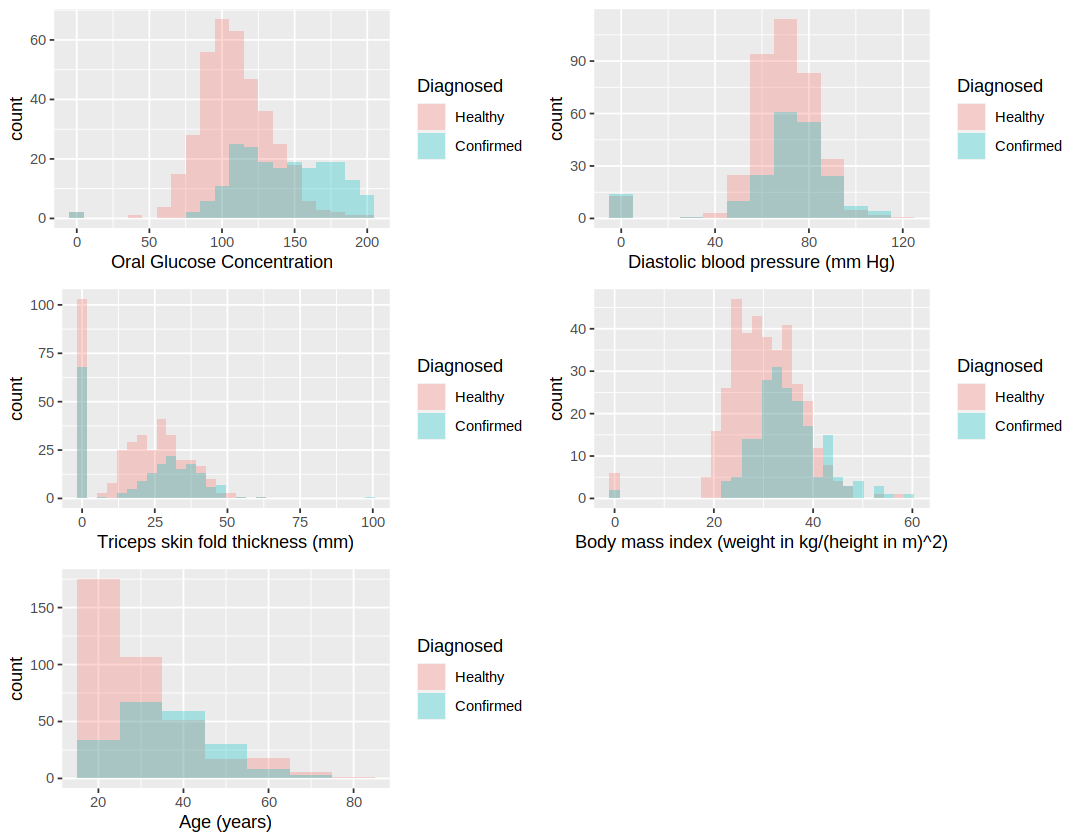

In [23]:
options(repr.plot.width = 9, repr.plot.height = 7)
glucose_concentration_distribution <- ggplot(diabetes_training, aes(x = glucose, fill = outcome)) +
                                        geom_histogram(alpha = 0.3, position = "identity", binwidth = 10) +
                                        labs(x = "Oral Glucose Concentration", fill = "Diagnosed") 

blood_pressure_distribution <- ggplot(diabetes_training, aes(x = blood_pressure, fill = outcome)) +
                                        geom_histogram(alpha = 0.3, position = "identity", binwidth = 10) +
                                        labs(x = "Diastolic blood pressure (mm Hg)", fill = "Diagnosed")

skin_thickness_distribution <- ggplot(diabetes_training, aes(x = skin_thickness, fill = outcome)) +
                                        geom_histogram(alpha = 0.3, position = "identity") +
                                        labs(x = "Triceps skin fold thickness (mm)", fill = "Diagnosed")

bmi_distribution <- ggplot(diabetes_training, aes(x = bmi, fill = outcome)) +
                                        geom_histogram(alpha = 0.3, position = "identity") +
                                        labs(x = "Body mass index (weight in kg/(height in m)^2)", fill = "Diagnosed")

age_distribution <- ggplot(diabetes_training, aes(x = age, fill = outcome)) +
                                        geom_histogram(alpha = 0.3, position = "identity", binwidth = 10) +
                                        labs(x = "Age (years)", fill = "Diagnosed")

grid.arrange(glucose_concentration_distribution, blood_pressure_distribution, skin_thickness_distribution, bmi_distribution, age_distribution, nrow = 3)